*Python Machine Learning 3rd Edition* by [Sebastian Raschka](https://sebastianraschka.com) & [Vahid Mirjalili](http://vahidmirjalili.com), Packt Publishing Ltd. 2019

Code Repository: https://github.com/rasbt/python-machine-learning-book-3rd-edition

Code License: [MIT License](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/LICENSE.txt)

# Chapter 13: Parallelizing Neural Network Training with TensorFlow  (Part 2/2)


Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

In [1]:
%load_ext watermark
%watermark -a "Sebastian Raschka & Vahid Mirjalili" -u -d -p numpy,scipy,matplotlib,tensorflow

Sebastian Raschka & Vahid Mirjalili 
last updated: 2019-11-24 

numpy 1.17.3
scipy 1.3.2
matplotlib 3.1.1
tensorflow 2.0.0


In [2]:
%matplotlib inline

## Building a neural network model in TensorFlow

### The TensorFlow Keras API (tf.keras)

### Building a linear regression model

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

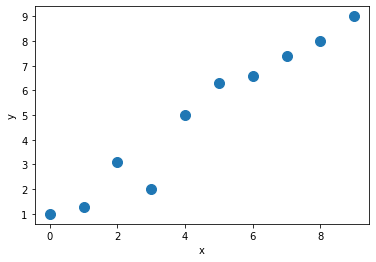

In [4]:
X_train = np.arange(10).reshape((10, 1))
y_train = np.array([1.0, 1.3, 3.1,
                    2.0, 5.0, 6.3,
                    6.6, 7.4, 8.0,
                    9.0])


plt.plot(X_train, y_train, 'o', markersize=10)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [5]:
X_train_norm = (X_train - np.mean(X_train))/np.std(X_train)

ds_train_orig = tf.data.Dataset.from_tensor_slices(
    (tf.cast(X_train_norm, tf.float32),
     tf.cast(y_train, tf.float32)))

In [6]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.w = tf.Variable(0.0, name='weight')
        self.b = tf.Variable(0.0, name='bias')

    def call(self, x):
        return self.w*x + self.b


model = MyModel()

model.build(input_shape=(None, 1))
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [7]:
def loss_fn(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))


## testing the function:
yt = tf.convert_to_tensor([1.0])
yp = tf.convert_to_tensor([1.5])

loss_fn(yt, yp)

<tf.Tensor: id=33, shape=(), dtype=float32, numpy=0.25>

In [8]:
def train(model, inputs, outputs, learning_rate):
    with tf.GradientTape() as tape:
        current_loss = loss_fn(model(inputs), outputs)
    dW, db = tape.gradient(current_loss, [model.w, model.b])
    model.w.assign_sub(learning_rate * dW)
    model.b.assign_sub(learning_rate * db)

In [9]:
tf.random.set_seed(1)

num_epochs = 200
log_steps = 100
learning_rate = 0.001
batch_size = 1
steps_per_epoch = int(np.ceil(len(y_train) / batch_size))


ds_train = ds_train_orig.shuffle(buffer_size=len(y_train))
ds_train = ds_train.repeat(count=None)
ds_train = ds_train.batch(1)

Ws, bs = [], []

for i, batch in enumerate(ds_train):
    if i >= steps_per_epoch * num_epochs:
        break
    Ws.append(model.w.numpy())
    bs.append(model.b.numpy())

    bx, by = batch
    loss_val = loss_fn(model(bx), by)

    train(model, bx, by, learning_rate=learning_rate)
    if i%log_steps==0:
        print('Epoch {:4d} Step {:2d} Loss {:6.4f}'.format(
              int(i/steps_per_epoch), i, loss_val))

Epoch    0 Step  0 Loss 43.5600
Epoch   10 Step 100 Loss 0.7530
Epoch   20 Step 200 Loss 20.1759
Epoch   30 Step 300 Loss 23.3976
Epoch   40 Step 400 Loss 6.3481
Epoch   50 Step 500 Loss 4.6356
Epoch   60 Step 600 Loss 0.2411
Epoch   70 Step 700 Loss 0.2036
Epoch   80 Step 800 Loss 3.8177
Epoch   90 Step 900 Loss 0.9416
Epoch  100 Step 1000 Loss 0.7035
Epoch  110 Step 1100 Loss 0.0348
Epoch  120 Step 1200 Loss 0.5404
Epoch  130 Step 1300 Loss 0.1170
Epoch  140 Step 1400 Loss 0.1195
Epoch  150 Step 1500 Loss 0.0944
Epoch  160 Step 1600 Loss 0.4670
Epoch  170 Step 1700 Loss 2.0695
Epoch  180 Step 1800 Loss 0.0020
Epoch  190 Step 1900 Loss 0.3612


Final Parameters: 2.6576622 4.8798566


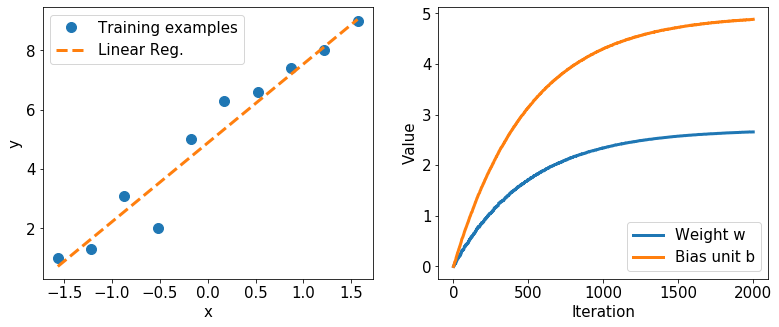

In [10]:
print('Final Parameters:', model.w.numpy(), model.b.numpy())


X_test = np.linspace(0, 9, num=100).reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)

y_pred = model(tf.cast(X_test_norm, dtype=tf.float32))


fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Training examples', 'Linear Reg.'], fontsize=15)
ax.set_xlabel('x', size=15)
ax.set_ylabel('y', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(Ws, lw=3)
plt.plot(bs, lw=3)
plt.legend(['Weight w', 'Bias unit b'], fontsize=15)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Value', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
#plt.savefig('ch13-linreg-1.pdf')

plt.show()

### Model training via the .compile() and .fit() methods

In [11]:
tf.random.set_seed(1)
model = MyModel()
#model.build((None, 1))

model.compile(optimizer='sgd', 
              loss=loss_fn,
              metrics=['mae', 'mse'])

In [12]:
model.fit(X_train_norm, y_train, 
          epochs=num_epochs, batch_size=batch_size,
          verbose=1)


Train on 10 samples
Epoch 1/200
10/10 [==============================] - 0s 31ms/sample - loss: 27.8562 - mae: 4.5967 - mse: 27.8562
Epoch 2/200
10/10 [==============================] - 0s 2ms/sample - loss: 18.6235 - mae: 3.7249 - mse: 18.6235
Epoch 3/200
10/10 [==============================] - 0s 2ms/sample - loss: 12.5081 - mae: 3.0572 - mse: 12.5081
Epoch 4/200
10/10 [==============================] - 0s 2ms/sample - loss: 8.4484 - mae: 2.4816 - mse: 8.4484
Epoch 5/200
10/10 [==============================] - 0s 2ms/sample - loss: 5.7520 - mae: 2.0644 - mse: 5.7520
Epoch 6/200
10/10 [==============================] - 0s 2ms/sample - loss: 3.9580 - mae: 1.7283 - mse: 3.9580
Epoch 7/200
10/10 [==============================] - 0s 2ms/sample - loss: 2.7617 - mae: 1.4792 - mse: 2.7617
Epoch 8/200
10/10 [==============================] - 0s 2ms/sample - loss: 1.9714 - mae: 1.2577 - mse: 1.9714
Epoch 9/200
10/10 [==============================] - 0s 2ms/sample - loss: 1.4485 - mae: 1.09

10/10 [==============================] - 0s 2ms/sample - loss: 0.4136 - mae: 0.4875 - mse: 0.4136
Epoch 75/200
10/10 [==============================] - 0s 2ms/sample - loss: 0.4136 - mae: 0.4810 - mse: 0.4136
Epoch 76/200
10/10 [==============================] - 0s 2ms/sample - loss: 0.4140 - mae: 0.4874 - mse: 0.4140
Epoch 77/200
10/10 [==============================] - 0s 2ms/sample - loss: 0.4140 - mae: 0.4874 - mse: 0.4140
Epoch 78/200
10/10 [==============================] - 0s 2ms/sample - loss: 0.4135 - mae: 0.4810 - mse: 0.4135
Epoch 79/200
10/10 [==============================] - 0s 2ms/sample - loss: 0.4137 - mae: 0.4840 - mse: 0.4137
Epoch 80/200
10/10 [==============================] - 0s 2ms/sample - loss: 0.4138 - mae: 0.4855 - mse: 0.4138
Epoch 81/200
10/10 [==============================] - 0s 1ms/sample - loss: 0.4132 - mae: 0.4876 - mse: 0.4132
Epoch 82/200
10/10 [==============================] - 0s 2ms/sample - loss: 0.4138 - mae: 0.4899 - mse: 0.4138
Epoch 83/200
1

10/10 [==============================] - 0s 1ms/sample - loss: 0.4130 - mae: 0.4828 - mse: 0.4130
Epoch 148/200
10/10 [==============================] - 0s 1ms/sample - loss: 0.4140 - mae: 0.4875 - mse: 0.4140
Epoch 149/200
10/10 [==============================] - 0s 1ms/sample - loss: 0.4133 - mae: 0.4924 - mse: 0.4133
Epoch 150/200
10/10 [==============================] - 0s 1ms/sample - loss: 0.4137 - mae: 0.4875 - mse: 0.4137
Epoch 151/200
10/10 [==============================] - 0s 1ms/sample - loss: 0.4138 - mae: 0.4866 - mse: 0.4138
Epoch 152/200
10/10 [==============================] - 0s 1ms/sample - loss: 0.4133 - mae: 0.4924 - mse: 0.4133
Epoch 153/200
10/10 [==============================] - 0s 1ms/sample - loss: 0.4140 - mae: 0.4889 - mse: 0.4140
Epoch 154/200
10/10 [==============================] - 0s 1ms/sample - loss: 0.4140 - mae: 0.4895 - mse: 0.4140
Epoch 155/200
10/10 [==============================] - 0s 1ms/sample - loss: 0.4138 - mae: 0.4835 - mse: 0.4138
Epoch 

2.7058775 4.971019


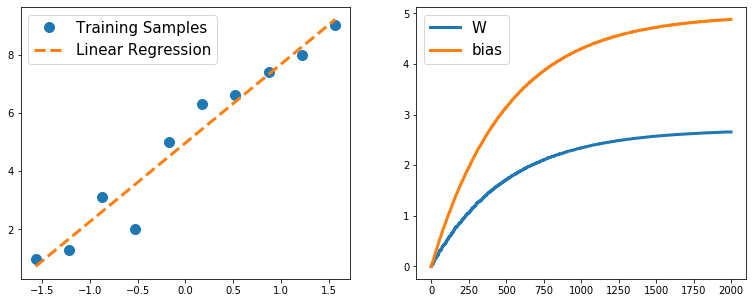

In [13]:
print(model.w.numpy(), model.b.numpy())


X_test = np.linspace(0, 9, num=100).reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)

y_pred = model(tf.cast(X_test_norm, dtype=tf.float32))


fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Training Samples', 'Linear Regression'], fontsize=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(Ws, lw=3)
plt.plot(bs, lw=3)
plt.legend(['W', 'bias'], fontsize=15)
plt.show()

## Building a multilayer perceptron for classifying flowers in the Iris dataset

In [14]:
import tensorflow_datasets as tfds



iris, iris_info = tfds.load('iris', with_info=True)

print(iris_info)

tfds.core.DatasetInfo(
    name='iris',
    version=1.0.0,
    description='This is perhaps the best known database to be found in the pattern recognition
literature. Fisher's paper is a classic in the field and is referenced
frequently to this day. (See Duda & Hart, for example.) The data set contains
3 classes of 50 instances each, where each class refers to a type of iris
plant. One class is linearly separable from the other 2; the latter are NOT
linearly separable from each other.
',
    urls=['https://archive.ics.uci.edu/ml/datasets/iris'],
    features=FeaturesDict({
        'features': Tensor(shape=(4,), dtype=tf.float32),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=150,
    splits={
        'train': 150,
    },
    supervised_keys=('features', 'label'),
    citation="""@misc{Dua:2019 ,
    author = "Dua, Dheeru and Graff, Casey",
    year = "2017",
    title = "{UCI} Machine Learning Repository",
    url = "http://archive

In [15]:
tf.random.set_seed(1)

ds_orig = iris['train']
ds_orig = ds_orig.shuffle(150, reshuffle_each_iteration=False)

print(next(iter(ds_orig)))

ds_train_orig = ds_orig.take(100)
ds_test = ds_orig.skip(100)

{'features': <tf.Tensor: id=117438, shape=(4,), dtype=float32, numpy=array([5.5, 3.5, 1.3, 0.2], dtype=float32)>, 'label': <tf.Tensor: id=117439, shape=(), dtype=int64, numpy=0>}


In [16]:
## checking the number of examples:

n = 0
for example in ds_train_orig:
    n += 1
print(n)


n = 0
for example in ds_test:
    n += 1
print(n)

100
50


In [17]:
ds_train_orig = ds_train_orig.map(
    lambda x: (x['features'], x['label']))

ds_test = ds_test.map(
    lambda x: (x['features'], x['label']))

next(iter(ds_train_orig))

(<tf.Tensor: id=117773, shape=(4,), dtype=float32, numpy=array([5.5, 3.5, 1.3, 0.2], dtype=float32)>,
 <tf.Tensor: id=117774, shape=(), dtype=int64, numpy=0>)

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='sigmoid', 
                          name='fc1', input_shape=(4,)),
    tf.keras.layers.Dense(3, name='fc2', activation='softmax')])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 16)                80        
_________________________________________________________________
fc2 (Dense)                  (None, 3)                 51        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
num_epochs = 100
training_size = 100
batch_size = 2
steps_per_epoch = np.ceil(training_size / batch_size)

ds_train = ds_train_orig.shuffle(buffer_size=training_size)
ds_train = ds_train.repeat()
ds_train = ds_train.batch(batch_size=batch_size)
ds_train = ds_train.prefetch(buffer_size=1000)


history = model.fit(ds_train, epochs=num_epochs,
                    steps_per_epoch=steps_per_epoch, 
                    verbose=0)

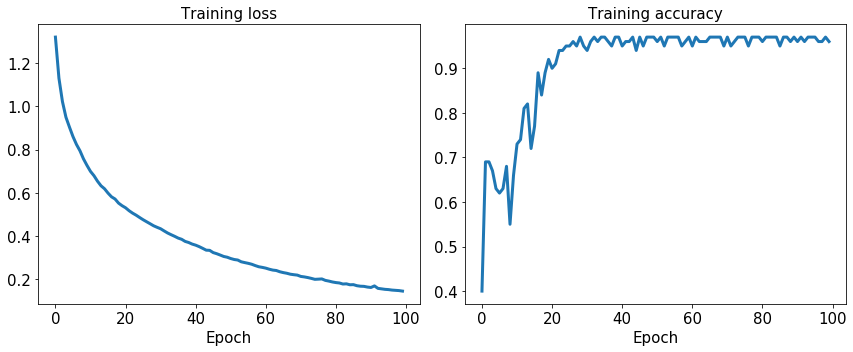

In [21]:
hist = history.history

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist['loss'], lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(hist['accuracy'], lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
#plt.savefig('ch13-cls-learning-curve.pdf')

plt.show()

### Evaluating the trained model on the test dataset

In [22]:
results = model.evaluate(ds_test.batch(50), verbose=0)
print('Test loss: {:.4f}   Test Acc.: {:.4f}'.format(*results))

Test loss: 0.1491   Test Acc.: 1.0000


### Saving and reloading the trained model

In [23]:
model.save('iris-classifier.h5', 
           overwrite=True,
           include_optimizer=True,
           save_format='h5')

In [24]:
model_new = tf.keras.models.load_model('iris-classifier.h5')

model_new.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 16)                80        
_________________________________________________________________
fc2 (Dense)                  (None, 3)                 51        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [25]:
results = model_new.evaluate(ds_test.batch(50), verbose=0)
print('Test loss: {:.4f}   Test Acc.: {:.4f}'.format(*results))

Test loss: 0.1491   Test Acc.: 1.0000


In [26]:
labels_train = []
for i,item in enumerate(ds_train_orig):
    labels_train.append(item[1].numpy())
    
labels_test = []
for i,item in enumerate(ds_test):
    labels_test.append(item[1].numpy())
print('Training Set: ',len(labels_train), 'Test Set: ', len(labels_test))

Training Set:  100 Test Set:  50


In [27]:
model.to_json()

'{"class_name": "Sequential", "config": {"name": "sequential", "layers": [{"class_name": "Dense", "config": {"name": "fc1", "trainable": true, "batch_input_shape": [null, 4], "dtype": "float32", "units": 16, "activation": "sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Dense", "config": {"name": "fc2", "trainable": true, "dtype": "float32", "units": 3, "activation": "softmax", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}]}, "keras_version": "2.2.4-tf", "backend": "tensor

## Choosing activation functions for multilayer neural networks


### Logistic function recap

In [28]:
import numpy as np

X = np.array([1, 1.4, 2.5]) ## first value must be 1
w = np.array([0.4, 0.3, 0.5])

def net_input(X, w):
    return np.dot(X, w)

def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))

def logistic_activation(X, w):
    z = net_input(X, w)
    return logistic(z)

print('P(y=1|x) = %.3f' % logistic_activation(X, w)) 

P(y=1|x) = 0.888


In [29]:
# W : array with shape = (n_output_units, n_hidden_units+1)
# note that the first column are the bias units

W = np.array([[1.1, 1.2, 0.8, 0.4],
              [0.2, 0.4, 1.0, 0.2],
              [0.6, 1.5, 1.2, 0.7]])

# A : data array with shape = (n_hidden_units + 1, n_samples)
# note that the first column of this array must be 1

A = np.array([[1, 0.1, 0.4, 0.6]])
Z = np.dot(W, A[0])
y_probas = logistic(Z)
print('Net Input: \n', Z)

print('Output Units:\n', y_probas) 

Net Input: 
 [1.78 0.76 1.65]
Output Units:
 [0.85569687 0.68135373 0.83889105]


In [30]:
y_class = np.argmax(Z, axis=0)
print('Predicted class label: %d' % y_class) 

Predicted class label: 0


### Estimating class probabilities in multiclass classification via the softmax function

In [31]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))

y_probas = softmax(Z)
print('Probabilities:\n', y_probas)

np.sum(y_probas)

Probabilities:
 [0.44668973 0.16107406 0.39223621]


1.0

In [32]:
import tensorflow as tf

Z_tensor = tf.expand_dims(Z, axis=0)
tf.keras.activations.softmax(Z_tensor)

<tf.Tensor: id=134666, shape=(1, 3), dtype=float64, numpy=array([[0.44668973, 0.16107406, 0.39223621]])>

### Broadening the output spectrum using a hyperbolic tangent

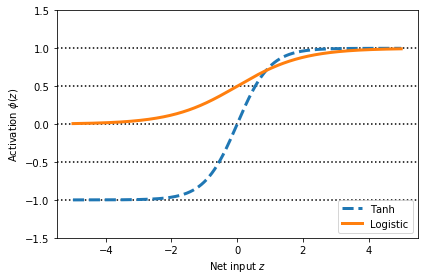

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

def tanh(z):
    e_p = np.exp(z)
    e_m = np.exp(-z)
    return (e_p - e_m) / (e_p + e_m)

z = np.arange(-5, 5, 0.005)
log_act = logistic(z)
tanh_act = tanh(z)
plt.ylim([-1.5, 1.5])
plt.xlabel('Net input $z$')
plt.ylabel('Activation $\phi(z)$')
plt.axhline(1, color='black', linestyle=':')
plt.axhline(0.5, color='black', linestyle=':')
plt.axhline(0, color='black', linestyle=':')
plt.axhline(-0.5, color='black', linestyle=':')
plt.axhline(-1, color='black', linestyle=':')
plt.plot(z, tanh_act,
    linewidth=3, linestyle='--',
    label='Tanh')
plt.plot(z, log_act,
    linewidth=3,
    label='Logistic')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


In [34]:
np.tanh(z)

array([-0.9999092 , -0.99990829, -0.99990737, ...,  0.99990644,
        0.99990737,  0.99990829])

In [35]:
import tensorflow as tf

tf.keras.activations.tanh(z)

<tf.Tensor: id=134668, shape=(2000,), dtype=float64, numpy=
array([-0.9999092 , -0.99990829, -0.99990737, ...,  0.99990644,
        0.99990737,  0.99990829])>

In [36]:
from scipy.special import expit

expit(z)

array([0.00669285, 0.00672617, 0.00675966, ..., 0.99320669, 0.99324034,
       0.99327383])

In [37]:
tf.keras.activations.sigmoid(z)

<tf.Tensor: id=134670, shape=(2000,), dtype=float64, numpy=
array([0.00669285, 0.00672617, 0.00675966, ..., 0.99320669, 0.99324034,
       0.99327383])>

### Rectified linear unit activation

In [38]:
import tensorflow as tf

tf.keras.activations.relu(z)

<tf.Tensor: id=134672, shape=(2000,), dtype=float64, numpy=array([0.   , 0.   , 0.   , ..., 4.985, 4.99 , 4.995])>

## Summary

# Appendix

## Splitting a dataset: danger of mixing train/test examples

In [39]:
## the correct way:
ds = tf.data.Dataset.range(15)
ds = ds.shuffle(15, reshuffle_each_iteration=False)


ds_train = ds.take(10)
ds_test = ds.skip(10)

ds_train = ds_train.shuffle(10).repeat(10)
ds_test = ds_test.shuffle(5)
ds_test = ds_test.repeat(10)

set_train = set()
for i,item in enumerate(ds_train):
    set_train.add(item.numpy())

set_test = set()
for i,item in enumerate(ds_test):
    set_test.add(item.numpy())

print(set_train, set_test)

{0, 1, 2, 3, 6, 7, 9, 10, 11, 13} {4, 5, 8, 12, 14}


In [40]:
## The wrong way:
ds = tf.data.Dataset.range(15)
ds = ds.shuffle(15, reshuffle_each_iteration=True)


ds_train = ds.take(10)
ds_test = ds.skip(10)

ds_train = ds_train.shuffle(10).repeat(10)
ds_test = ds_test.shuffle(5)
ds_test = ds_test.repeat(10)

set_train = set()
for i,item in enumerate(ds_train):
    set_train.add(item.numpy())

set_test = set()
for i,item in enumerate(ds_test):
    set_test.add(item.numpy())

print(set_train, set_test)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14} {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}


### Splitting a dataset using `tfds.Split`

In [41]:

##--------------------------- Attention ------------------------##
##                                                              ##
##     Note: currently, tfds.Split has a bug  in TF 2.0.0       ##
##                                                              ##
##  I.e., splitting [2, 1] is expected to result in             ##
##      100 train and 50 test examples                          ##
##                                                              ##
##  but instead, it results in 116 train and 34 test examples   ##
##                                                              ##
##--------------------------------------------------------------##

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

##  method 1: specifying percentage:
#first_67_percent = tfds.Split.TRAIN.subsplit(tfds.percent[:67])
#last_33_percent = tfds.Split.TRAIN.subsplit(tfds.percent[-33:])

#ds_train_orig = tfds.load('iris', split=first_67_percent)
#ds_test = tfds.load('iris', split=last_33_percent)


##  method 2: specifying the weights
split_train, split_test = tfds.Split.TRAIN.subsplit([2, 1])

ds_train_orig = tfds.load('iris', split=split_train)
ds_test = tfds.load('iris', split=split_test)

print(next(iter(ds_train_orig)))
print()
print(next(iter(ds_test)))


ds_train_orig = ds_train_orig.shuffle(100, reshuffle_each_iteration=True)
ds_test  = ds_test.shuffle(50, reshuffle_each_iteration=False)

ds_train_orig = ds_train_orig.map(
    lambda x: (x['features'], x['label']))

ds_test = ds_test.map(
    lambda x: (x['features'], x['label']))

print(next(iter(ds_train_orig)))


for j in range(5):
    labels_train = []
    for i,item in enumerate(ds_train_orig):
        labels_train.append(item[1].numpy())

    labels_test = []
    for i,item in enumerate(ds_test):
        labels_test.append(item[1].numpy())
    print('Training Set: ',len(labels_train), 'Test Set: ', len(labels_test))

    labels_test = np.array(labels_test)

    print(np.sum(labels_test == 0), np.sum(labels_test == 1), np.sum(labels_test == 2))

{'features': <tf.Tensor: id=135238, shape=(4,), dtype=float32, numpy=array([6.1, 2.8, 4.7, 1.2], dtype=float32)>, 'label': <tf.Tensor: id=135239, shape=(), dtype=int64, numpy=1>}

{'features': <tf.Tensor: id=135245, shape=(4,), dtype=float32, numpy=array([5.7, 3. , 4.2, 1.2], dtype=float32)>, 'label': <tf.Tensor: id=135246, shape=(), dtype=int64, numpy=1>}
(<tf.Tensor: id=135290, shape=(4,), dtype=float32, numpy=array([6.8, 2.8, 4.8, 1.4], dtype=float32)>, <tf.Tensor: id=135291, shape=(), dtype=int64, numpy=1>)
Training Set:  116 Test Set:  34
10 12 12
Training Set:  116 Test Set:  34
10 12 12
Training Set:  116 Test Set:  34
10 12 12
Training Set:  116 Test Set:  34
10 12 12
Training Set:  116 Test Set:  34
10 12 12


<br>
<br>
<br>

---

Readers may ignore the next cell.

In [42]:
! python ../.convert_notebook_to_script.py --input ch13_part2.ipynb --output ch13_part2.py

[NbConvertApp] Converting notebook ch13_part2.ipynb to script
[NbConvertApp] Writing 13911 bytes to ch13_part2.py
